In [1]:
from __future__ import print_function
 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D,GRU,Conv1D, MaxPooling1D,SpatialDropout1D
from keras.layers.recurrent import LSTM,GRU
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from keras.models import model_from_json
import numpy as np
import json
import requests
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df_all = pd.read_csv('data/19999_question_category_a_v16.csv')
print(f"df_all shape : {df_all.shape}")

df_all shape : (14247, 8)


In [3]:
mapping = df_all.category.astype('category').cat.categories
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [4]:
from NLP_JiebaSegmentor import JiebaSegmentor
jieba_dict_path1 = "jieba/dict_taiwan.txt"
jieba_dict_path2 = "jieba/userdict.txt"
jieba_dict_path3 = "jieba/dict.txt.big"
jieba_dict_path4 = "jieba/dict.txt.small"
jieba_dict_path5 = "jieba/dict_system.txt"
jieba_stopwords_path = "jieba/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2,
                              jieba_dict_path3,
                              jieba_dict_path4
                              #jieba_dict_path5
                             ],
                    stopwords=True,
                    stopwords_path=jieba_stopwords_path)

Building prefix dict from /project/at081-group3/Project_19999/19999_2RNN/jieba/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.u5f4d4d2a4ebf6cacbf248ccc4ee696aa.cache
Loading model cost 0.580 seconds.
Prefix dict has been built succesfully.


In [5]:
test_cut_raw_0 = js.lcut('FTP無法安裝', return_type='pandas')
test_cut_raw_0

,word
0,FTP
1,安裝


In [6]:
# x_train=np.loadtxt("x_train.txt",dtype=int)
# y_train=np.loadtxt("y_train.txt",dtype=int)
 
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)
# x_train = x_train[indices]
# y_train = y_train[indices]
 
# print('Loading data...')
# #x_train=np.loadtxt("x_train.txt",dtype=int)
# #y_train=np.loadtxt("y_train.txt",dtype=int)
# x_test=x_train[20000:]
# y_test=y_train[20000:]
# x_train=x_train[:20000]
# y_train=y_train[:20000]
# #x_test=x_train
# #y_test=y_train
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')
# print(x_train[:1])
# print('Pad sequences (samples x time)')

In [7]:
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target
0,"無法會員登入,顯示訊息:無效的帳號或使用者不存在。帳號:96122401",CAMP,CAMP,CAMP,CAMP,資訊系統,無法會員登入顯示訊息無效的帳號或不存在帳號,4
1,因今天有事請假，要補登先前的加班，但開啟camp後，出勤表單顯示的內容看起來像測試的，沒有最...,CAMP,CAMP,CAMP,CAMP,資訊系統,因有事請假要補登先前的加班但開啟camp後出勤表單顯示的內容像測試的沒有的時間也沒辦法使用已...,4
2,"手機簽核BPM有問題,都顯示亂碼 #18227",CAMP,CAMP,CAMP,CAMP,資訊系統,簽核bpm有問題都顯示亂碼,4
3,無法在手機上面使用CAMP進行表單簽核動作。分機：17132,CAMP,CAMP,CAMP,CAMP,資訊系統,無法在上面使用camp進行表單簽核動作,4
4,無法打開報單資料,CAMP,CAMP,CAMP,CAMP,資訊系統,無法打開報單資料,4


In [8]:
# w_pandas = js.lcut('無法會員登入 顯示訊息 無效的帳號或不存在 帳號'.strip(), return_type='pandas')
# w_list = list(w_pandas['word'])
# w_list

In [9]:
def cut_to_word(s):
    blCondition=True
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    combieNO=''
    beforeWord=''
    blAdd=True
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
        conditionWord = str(combieNO) + str(w)
        if combieNO != '' :# and len(conditionWord) == 4:
            combie = combie + w +','
            combie = combie+combieNO+w
            #print(combieNO+w)
        else:        
            if w in ['修改','顯示','申請單','問題','作業','系統'] and beforeWord!='' and blCondition and len(w)>1:#,,'問題','顯示',
                combie = combie +w
                combie = combie+','+beforeWord+w
            else:
                if w not in ['無法'] and len(w)>1:
                    combie = combie + w
                else:
                    blAdd = False
                 
        if i < len(w_list) - 1 and combie !='' and blAdd:
            combie = combie + ','
            
        blAdd = True
        
        if w in ['無法','不能'] and blCondition:#,'安裝','編輯','刪除','新增','作業','忘記','下載','上傳','系統','開啟'
            combieNO = w
        else:
            combieNO = ''
        beforeWord=w
    return combie    

def cut_to_word2(s):
    w_pandas = js.lcut(s, return_type='pandas')
    w_list = list(w_pandas['word'])
    combie = ''
    for i,w in enumerate(w_list):
        if w is ' ':
            continue
            
        combie = combie + w
                 
        if i < len(w_list) - 1:
            combie = combie + ','
            
    return combie  

df_all['cut_words'] = df_all['description_clean'].apply(lambda s: cut_to_word2(s.strip()))

In [10]:

print (cut_to_word('加班申請單'.strip()))

加班,申請單,加班申請單


In [11]:
# 資料打散
df_all = df_all.sample(frac=1).reset_index(drop=True)
df_all.head()

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
0,在家用自己電腦聯公司網路，BPM 都無法連上 #13320,網管,VPN連線,SSLVPN問題,無法登入,網路,在家用電腦聯公司網路bpm 都無法連上,3,"家用電腦,聯,公司,網路,bpm,"
1,使用者 網路經常斷線 出現驗證訊息.,網管,網路,電腦網路不通,網路不斷出現驗證訊息,網路,網常斷線 出現驗證訊息,3,"網常,斷線,出現,驗證,訊息"
2,在本機使用outlook，會漏信。,網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,在本機使用outlook會漏信,0,"本機,使用,outlook,漏信"
3,"1. 今天發生數次雲端當掉的狀況, 懷疑是網路不穩定造成 2. 附近同事也有相 同情況 ...",網管,網路,電腦網路不通,網路不通 (QRDC),網路,1. 發生數次雲端當掉的狀況 懷疑是網路不穩定造成 2. 附近也有相 同情況 以上均使用...,3,"1,發生,數次,雲端,當掉,狀況,懷疑,網路,穩定,造成,2,附近,相,情況,以上,使用,有線網路"
4,在Quanta domain外使用SSLVPN以後還是無法登入公司內網。,網管,網路,無法連到某台Server,無法連到某些Server,網路,在quanta domain外使用sslvpn以後公司內網,3,"quanta,domain,外,使用,sslvpn,以後,公司,內網"


In [12]:
df_all[3040:4010]

,description,category_a,category_b,category_c,category_d,category,description_clean,category_target,cut_words
3040,"User從大陸回台灣,但無法連線內部網路 上次回台可以連線內部網路",網管,網路,電腦網路不通,網路不通 (QRDC),網路,從回但無法連線內部網路 上次回台可以連線內部網路,3,"回,連線,內部網路,上次,回台,連線,內部網路"
3041,"最近的一個星期outlook mail收發執行超慢的,導致工作一直被耽擱.常常outlook...",網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,的一個星期outlook mail收發執行超慢的導致工作被耽擱.outlook 執行的bar...,0,"一個,星期,outlook,mail,收發,執行,超慢,導致,工作,耽擱,outlook,執..."
3042,詢問 Visio要到那裡安裝,網管,作業系統與印表機,軟體問題,軟體安裝問題,其他,詢問 visio要到安裝,2,"詢問,visio,到,安裝"
3043,昨天outlook的OST檔無法開啟，填19999問題單獲解決後，今天開啟outlook依然...,網管,Outlook與郵件,Outlook,其他問題,Outlook與郵件,outlook的ost檔填問題單獲後開啟outlook依然出現ost檔,0,"outlook,ost,檔,填,問題,單獲,後,開啟,outlook,依然,出現,ost,檔"
3044,帳號被lock住,SAP-168(QCI),Basis,其它,無法logon SAP,SAP,帳號被lock住,1,"帳號,lock,住"
3045,我的筆電自從上週變更密碼之後 Outlook再也無法連上Exchange server收發E...,網管,Outlook與郵件,Outlook,郵件無法收發,Outlook與郵件,我的筆電上週變更密碼之後 outlook再也無法連上exchange server收發 我...,0,"筆電,上週,變更,密碼,之後,outlook,再也,連上,exchange,server,收..."
3046,詢問哪裡可以查詢固定資產明細。,BPM平台系統,事務類相關服務,固定資產移轉單,相關操作詢問,資訊系統,詢問可以固定資產明細,4,"詢問,固定資產,明細"
3047,點選excel import連結，系統回復應用程式中發生伺服器錯誤 行 67: string...,R&D資訊系統,測試相關服務,【QDSM】測試設備預約管理系統,相關操作詢問,資訊系統,點選excel import連結系統回復應用程式中發生伺服器錯誤 行 67 string f...,4,"點選,excel,import,連結,系統,回復,應用程式,中,發生,伺服器,錯誤,行,67..."
3048,總經理的信與薪資單都無法開啟，一開啟outlook就會當機 #12975,網管,Outlook與郵件,Outlook,無法開啟薪資單,Outlook與郵件,總經理的信與薪資單都一開啟outlook就會當機,0,"總經理,信,薪資單,開啟,outlook,就會,當機"
3049,can not upload,SAP-168(QCI),SD,Sales Process,Delivery issue,SAP,can not upload,1,"can,not,upload"


In [13]:
# 切分資料
X = df_all['cut_words']
y = df_all['category_target']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 40)

In [15]:
X_train.head()

4483                                       plm,安裝,java,錯誤
2179                                           有線,無線網路,不通
4810                              寄件,過的,人,自動,儲存,開關機,之後,清除
2209                                電腦,重新安裝,後防,毒,出現,更新,問題
5179    達豐,使用,sap168,zkd9,勾,bom,時,應該,出現,3,個料號,只,出現,一個,...
Name: cut_words, dtype: object

In [16]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_val_one_hot = np_utils.to_categorical(y_val)
print (y_train_one_hot[0])
print (y_val_one_hot[0])
# 總共類別數
num_classes = len((y_train_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0.]
num_classes = 5


In [17]:
# # 標點符號過濾
# WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# 字典數量
NUM_WORDS = 5001
# 向量長度
MAX_LEN = 30

token_intent = Tokenizer(num_words=NUM_WORDS,
                        split=",")
# token_intent = Tokenizer(filters=WORD_FILTERS,
#                         num_words=NUM_WORDS,
#                         split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
token_intent.fit_on_texts(X_train)
token_intent.fit_on_texts(X_val)

def preprocessing(x, max_len):

    #將文字轉為數字序列
    train_seq_intent = token_intent.texts_to_sequences(x)

    # 截長補短，讓所有數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=MAX_LEN)
    # print train_data_intent.shape
    return data

x_train = preprocessing(X_train, max_len=MAX_LEN)
x_val = preprocessing(X_val, max_len=MAX_LEN)

In [18]:
x_train

array([[   0,    0,    0, ...,   38,  507,   24],
       [   0,    0,    0, ...,   84,   10,    3],
       [   0,    0,    0, ..., 2595,   79,  856],
       ...,
       [   0,    0,    0, ...,    0,  703,  441],
       [   0,    0,    0, ...,    0,    1,    7],
       [   0,    0,    0, ...,   40,    1,    3]], dtype=int32)

In [19]:
# set parameters:
max_features = 5001
maxlen = 100
batch_size = 20
embedding_dims = 50
filters = 100
kernel_size = 10
hidden_dims = 250
epochs = 10
train_ratio = 0.9

In [20]:
#CCN-87.7%,89%,90.5%,90%
#https://www.kaggle.com/kakiac/deep-learning-4-text-classification-cnn-bi-lstm
#https://mlwhiz.com/blog/2019/03/09/deeplearning_architectures_text_classification/
from keras.layers.merge import concatenate, add
from keras.layers import CuDNNGRU,Input,MaxPooling1D
from keras.models import Sequential, load_model,Model
def build_CNN(num_classes, vocab_size, sentence_max_len,embedding_dim):
    inp = Input(shape=(sentence_max_len, ))
    embed_size = 240
    x = Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len)(inp)
    
    convs = []
    filter_sizes = [3,4,5] # in the loop, first apply 3 as size, then 4 then 5

    x = Dropout(0.5)(x)
    
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(x)
        #kernel is the filter
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)

    l_merge = concatenate(convs, axis=1)
    
    # activated if extra_convoluted is true at the def
    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=19, activation='relu')(x)
    pool = MaxPooling1D(pool_size=3)(conv)
    x = Dropout(0.5)(l_merge)  
    
    #x = Conv1D(filters=512,kernel_size=10,padding='same', activation='relu')(x)
    #x = GlobalMaxPooling1D()(x)
    #x = Bidirectional(CuDNNGRU(512, return_sequences=True))(x)
    #x = GlobalMaxPooling1D()(x)
    
    #x = Flatten()(x)
    
    
    
    #x = Dense(128, activation="relu")(x)
    #x = Dropout(0.5)(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    #x = Dense(6, activation="sigmoid")(x)
    outp = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=outp)
    print(model.summary())
    return model;
    

In [21]:
#https://github.com/LB-Yu/TextCNN-keras/blob/master/TextCNN-keras.ipynb
import keras.layers as L
import keras
def text_cnn(num_classes, vocab_size, sequence_length, embedding_size, 
               drop_out=0.5 ,l2_reg_lambda=0.0):
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    filter_sizes = [3,4,5]
    num_filters=128
    # embedding layer
    #if embedding_matrix is None:
    embedding = L.Embedding(vocab_size, embedding_size, name='embedding')(input_x)
    #else:
    #    embedding = L.Embedding(vocab_size, embedding_size, weights=[embedding_matrix], name='embedding')(input_x)
    expend_shape = [embedding.get_shape().as_list()[1], embedding.get_shape().as_list()[2], 1]
    # embedding_chars = K.expand_dims(embedding, -1)    # 4D tensor [batch_size, seq_len, embeding_size, 1] seems like a gray picture
    embedding_chars = L.Reshape(expend_shape)(embedding)
    
    # conv->max pool
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        conv = L.Conv2D(filters=num_filters, 
                        kernel_size=[filter_size, embedding_size],
                        strides=1,
                        padding='valid',
                        activation='relu',
                        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1),
                        bias_initializer=keras.initializers.constant(value=0.1),
                        name=('conv_%d' % filter_size))(embedding_chars)
        # print("conv-%d: " % i, conv)
        max_pool = L.MaxPool2D(pool_size=[sequence_length - filter_size + 1, 1],
                               strides=(1, 1),
                               padding='valid',
                               name=('max_pool_%d' % filter_size))(conv)
        pooled_outputs.append(max_pool)
        # print("max_pool-%d: " % i, max_pool)
    
    # combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = L.Concatenate(axis=3)(pooled_outputs)
    h_pool_flat = L.Reshape([num_filters_total])(h_pool)
    # add dropout
    dropout = L.Dropout(drop_out)(h_pool_flat)
    
    # output layer
    output = L.Dense(num_classes,
                     kernel_initializer='glorot_normal',
                     bias_initializer=keras.initializers.constant(0.1),
                     activation='softmax',
                     name='output')(dropout)
    model = keras.models.Model(inputs=input_x, outputs=output)
    model.summary()
    return model

In [22]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len,embedding_dim):
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
                     
    # We add a vanilla hidden layer:
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [23]:
model = text_cnn(num_classes, NUM_WORDS, MAX_LEN,256)
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      1280256     input_x[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 30, 256, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 28, 1, 128)   98432       reshape_1[0][0]                  
__________________________________________________________________________________________________
conv_4 (Co

In [24]:
model_path = '{}.h5'.format('19999_rnn')

epochs = 50
batch_size = 128
train_ratio = 0.9

checkpoint = ModelCheckpoint(model_path, monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)

model_history = model.fit(x=x_train, y=y_train_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio,
                            callbacks = [checkpoint, earlystop])

Train on 10257 samples, validate on 1140 samples
Epoch 1/50
10257/10257 [==============================] - 3s 260us/step - loss: 0.8963 - acc: 0.6807 - val_loss: 0.4533 - val_acc: 0.8632

Epoch 00001: val_acc improved from -inf to 0.86316, saving model to 19999_rnn.h5
Epoch 2/50
10257/10257 [==============================] - 0s 48us/step - loss: 0.3331 - acc: 0.9020 - val_loss: 0.3136 - val_acc: 0.9018

Epoch 00002: val_acc improved from 0.86316 to 0.90175, saving model to 19999_rnn.h5
Epoch 3/50
10257/10257 [==============================] - 0s 48us/step - loss: 0.2018 - acc: 0.9386 - val_loss: 0.3002 - val_acc: 0.9026

Epoch 00003: val_acc improved from 0.90175 to 0.90263, saving model to 19999_rnn.h5
Epoch 4/50
10257/10257 [==============================] - 1s 49us/step - loss: 0.1430 - acc: 0.9574 - val_loss: 0.2895 - val_acc: 0.9026

Epoch 00004: val_acc did not improve from 0.90263
Epoch 5/50
10257/10257 [==============================] - 0s 49us/step - loss: 0.1044 - acc: 0.9708

In [25]:
from keras import models 
model=models.load_model(model_path)

In [26]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['add', 'concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


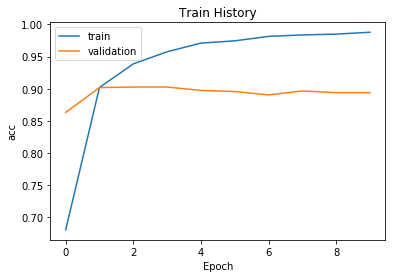

In [27]:
show_train_history(model_history,'acc','val_acc')

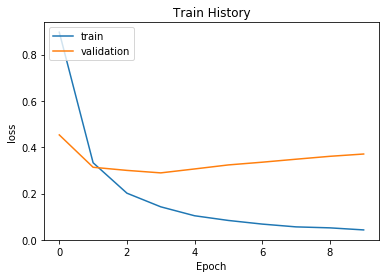

In [28]:
show_train_history(model_history,'loss','val_loss')

In [29]:
def to_cat_name(x): 
        return mapping[x]
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, y_predict_probability

def predict_class(data):
    y_predict_probability = model.predict(data, batch_size=64, verbose=1)
    predict_arr = []
    predictClass = []
    for row in y_predict_probability: 
            classIndex=0
            selectClass=0
            selectProbability=0
            for item in row: 
                #print(float(item))
                if(selectProbability <= float(item)):
                    #print(classIndex)
                    selectProbability=float(item)
                    selectClass=classIndex
                classIndex=classIndex+1
            predictClass.append(selectClass)
            
    return to_cat_name(predictClass),predictClass,y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict_class(x_val)

2850/2850 [==============================] - 0s 66us/step


In [30]:
answer_name = to_cat_name(y_val)

In [31]:
#model.predict_classes(x_val)

In [32]:
x_val

array([[   0,    0,    0, ...,   31,  451, 1050],
       [   0,    0,    0, ...,   83,  180,  603],
       [   0,    0,    0, ...,   71,   20, 2996],
       ...,
       [   0,    0,    0, ...,  246, 4863,  126],
       [   0,    0,    0, ...,   29,   18,  280],
       [   0,    0,    0, ...,  236,  257,  193]], dtype=int32)

In [33]:
mapping

Index(['Outlook與郵件', 'SAP', '其他', '網路', '資訊系統'], dtype='object')

In [34]:
# model.predict(x_val)

In [35]:
# predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
#               '2_y_predict':y_predict,
#               '3_y_predict_name':y_predict_name,
#               '4_answer':df_test.target,
#               '5_y_predict_probability':list(y_predict_probability)})
# predict_df

In [36]:
predict_df = pd.DataFrame({
              '1_sentence':X_val,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_val,
              '5_answer_name':answer_name,
              '6_y_predict_probability':list(y_predict_probability)})
# predict_df

In [37]:
# accuracy
accuracy = 1 - (float(len(predict_df[predict_df['2_y_predict'] != predict_df['4_answer']])))/(len(predict_df))
print ('accuracy : {} !!!!!!!!'.format(accuracy))

accuracy : 0.9091228070175439 !!!!!!!!


In [38]:
differ_ans=predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]
differ_ans

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
6601,"某人,excel,附件,之前,開啟,今日,變",2,其他,0,Outlook與郵件,"[0.47862586, 0.0069456054, 0.492197, 0.0081652..."
11975,"outlook,web,ocs,",0,Outlook與郵件,3,網路,"[0.9951591, 9.999403e-05, 0.004200678, 0.00043..."
11704,"os,windows,連結上,無線網路",2,其他,3,網路,"[0.007366746, 0.00055041676, 0.83766377, 0.152..."
2522,"10.243,23.56,login,12,31,晚上,發生,同樣,情形",3,網路,1,SAP,"[0.22373869, 0.04721642, 0.16509481, 0.3692169..."
7044,"今日,9,點有,訪客",3,網路,4,資訊系統,"[0.0049367608, 0.008746125, 0.021615673, 0.883..."
11897,"outlook,ssl,vpn,帳號密碼,過期,出現,驗證,視窗,90",3,網路,2,其他,"[0.06201331, 6.867179e-05, 0.015233929, 0.9221..."
8798,"撥,icon,消失",0,Outlook與郵件,2,其他,"[0.42042786, 0.2430873, 0.12411946, 0.03642872..."
9191,"orcad,顯示,licence,平常,licence,用完,訊息,晚,應該,太,用完",2,其他,4,資訊系統,"[0.061466027, 0.035704166, 0.47656864, 0.13543..."
5596,"老闆,密碼,填單",2,其他,4,資訊系統,"[0.11243102, 0.1162966, 0.44584233, 0.11545734..."
11220,"輸入,帳號密碼,之後,停留,遠端,連結,視窗",0,Outlook與郵件,1,SAP,"[0.30328307, 0.14609541, 0.25902724, 0.2209659..."


In [39]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(answer_name),
            rownames=['predict'], colnames=['answer'])

answer,Outlook與郵件,SAP,其他,網路,資訊系統
predict,,,,,
Outlook與郵件,761,4,11,21,4
SAP,2,304,5,12,13
其他,15,13,160,38,15
網路,16,11,27,1118,20
資訊系統,6,11,7,8,248


In [40]:

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# score = loaded_model.evaluate(x_test, y_test, verbose=0)
# print(score)

In [41]:
pd.DataFrame(differ_ans).to_csv('CNN_v4.csv')